In [157]:
# Setup

!pip install pyro-ppl
!pip install scipy
!pip install matplotlib

     |████████████████████████████████| 12.4 MB 3.6 MB/s eta 0:00:01
  Using cached pyparsing-2.4.6-py2.py3-none-any.whl (67 kB)
     |████████████████████████████████| 113 kB 22.2 MB/s eta 0:00:01


In [225]:
import pyro
import torch
import torch.tensor as tensor
import pyro.distributions as dist
from pyro.distributions import Binomial, Categorical, Dirichlet, DirichletMultinomial, Beta, BetaBinomial, Uniform, Gamma

import numpy as np

import scipy
from scipy.stats import binom as ScipyBinom
from matplotlib import pyplot

from collections import namedtuple

seed = 0

In [45]:
# Measuring overhead
import time

# .1s
l = []
start = time.time()
for i in range(int(1e6)):
    l.append(i)

if len(l) > 5:
    print("Done")
print(f"Scalar version took: {time.time() - start}")

# 30x slower, 3.2s
l = []
start = time.time()
for i in range(int(1e6)):
    l.append(tensor(i))

if len(l) > 5:
    print("Done")
print(f"Tensor version took: {time.time() - start}")

# do it in one pass
# this wraps the array in tensor, aka tensor([]),
# but accessing a single element gives back a tensor
l = []
start = time.time()
for i in range(int(1e6)):
    l.append(i)

# .13s 
l = torch.tensor(l)
if len(l) > 5:
    print("Done")
print(f"Tensor convert array version took: {time.time() - start}")

Done
Scalar version took: 0.10182571411132812
Done
Tensor version took: 3.2070868015289307
Done
Tensor convert array version took: 0.13137578964233398


In [84]:
###### all named tuples used

Samples = namedtuple("Samples", ["ctrls", "cases"])

In [402]:
# nSamples shape: [nConditions, 2] , last dim is ctrls, cases
def genData(nSamples, pDs, diseaseFractions, rrShape, rrMeans, afMean, afShape, nGenes = 20000):
    # TODO: assert shapes match
    print("TESTING WITH: nSamples", nSamples, "rrMean", rrMeans, "rrShape", rrShape, "afMean", afMean, "afShape", afShape, "diseaseFractions", diseaseFractions, "pDs", pDs)
    
    nConditions = len(nSamples)
    probs = []
    afDist = Gamma(concentration=afShape,rate=afShape/afMean)
    rrDist = Gamma(concentration=rrShape,rate=rrShape/rrMeans)
    rrNullDist = Gamma(concentration=rrShape,rate=rrShape.expand(nConditions))
    
    # shape == [nGenes, nConditions]
    afs = afDist.sample([nGenes,])   
    rrs = rrDist.sample([nGenes,])
    rrNulls = rrNullDist.sample([nGenes,])
    for geneIdx in range(nGenes):
        geneProbs = []
        for conditionIdx in range(nConditions):
            # TODO: sample from uniform
            if geneIdx < nGenes * diseaseFractions[conditionIdx]:
                rr = rrs[geneIdx, conditionIdx]
            else:
                rr = rrNulls[geneIdx, conditionIdx]
            
            probVgivenD = pVgivenD(rr, afs[geneIdx])
            probVgivenNotD = pVgivenNotD(pDs[conditionIdx], afs[geneIdx], probVgivenD)
            
            geneProbs.append([probVgivenNotD, probVgivenD])
        probs.append(geneProbs)
    probs = tensor(probs)
    print("probs", probs, probs.shape)
    # This should not be slow but is
    # https://github.com/pytorch/pytorch/issues/11389
    start = time.time()
    altCounts = Binomial(total_count=nSamples.expand([nGenes, *nSamples.shape]), probs=probs).sample()
    print("final sampling took", time.time() - start)
    
    return altCounts, probs

In [403]:
disease1 = Samples(1e5, 1e3)
disease2 = Samples(1e5, 1e3)
diseaseBoth = Samples(1e5, 1e2)

nSamples = [disease1, disease2, diseaseBoth]
nSamples = tensor(nSamples)

pDs = nSamples[:, 1]/nSamples.sum(1)
diseaseFractions = tensor([.1, .1, .05])
rrShape = tensor(10.)
rrMeans = tensor([10., 10., 5.])
afMean = tensor(1e-4)
afShape = tensor(10.)
pooledControls = True
altCountsByGene, afsByGene = genData(nSamples=nSamples, pDs=pDs, diseaseFractions=diseaseFractions, rrShape=rrShape, rrMeans=rrMeans, afMean=afMean, afShape=afShape)

TESTING WITH: nSamples tensor([[100000.,   1000.],
        [100000.,   1000.],
        [100000.,    100.]]) rrMean tensor([10., 10.,  5.]) rrShape tensor(10.) afMean tensor(1.0000e-04) afShape tensor(10.) diseaseFractions tensor([0.1000, 0.1000, 0.0500]) pDs tensor([0.0099, 0.0099, 0.0010])
probs tensor([[[1.1404e-04, 5.6165e-04],
         [1.0049e-04, 1.9158e-03],
         [1.1826e-04, 3.2455e-04]],

        [[6.9787e-05, 1.2106e-03],
         [7.2937e-05, 8.9554e-04],
         [8.0781e-05, 3.8169e-04]],

        [[7.6722e-05, 1.2136e-03],
         [8.1063e-05, 7.7954e-04],
         [8.7540e-05, 5.2657e-04]],

        ...,

        [[9.9826e-05, 1.1739e-04],
         [1.0006e-04, 9.3924e-05],
         [1.0004e-04, 5.6811e-05]],

        [[1.5216e-04, 2.1510e-04],
         [1.5281e-04, 1.5013e-04],
         [1.5283e-04, 1.0965e-04]],

        [[5.3258e-05, 9.6847e-05],
         [5.3840e-05, 3.8642e-05],
         [5.3702e-05, 4.1085e-05]]]) torch.Size([20000, 3, 2])
final sampling took 

In [394]:
# Likelihood functions
# These assume univariate currently

# rr: relative risk
def pVgivenD(rr, pV):
    return (rr * pV) / (rr * pV + (1 - pV))

# pD: prevalence
# pV: allele frequency
def pVgivenNotD(pD, pV, pVgivenD):
    p = (pV - pD*pVgivenD) / (1 - pD)
    assert(p >= 0)
    return p

def pDgivenV(pD, pVgivenD, pV):
    return pVgivenD * pD / pV

def llUnivariateSingleGene(xCtrl, xCase, pD, pi0, pi1, pDgivenV):
    global i
    n = xCtrl + xCase
    print("pd2", pD)
    #convex function, so by jensen's sum of logs is fine (always <= the log of sum)
#     return torch.log(pi0 * torch.exp(Binomial(total_count=n, probs=pD).log_prob(xCase)) + pi1*torch.exp(Binomial(total_count=n, probs=pDgivenV).log_prob(xCase)))
    return pi0 * Binomial(total_count=n, probs=pD).log_prob(xCase) + pi1*Binomial(total_count=n, probs=pDgivenV).log_prob(xCase)

# shape of altCountsByGene: [nGenes, nConditions, 2]
# last dimension is 
# 2nd dimension altCountsCasesByGene must match controls, or the control nConditions must be 1 (pooled controls)
def likelihoodUnivariate(altCountsByGene, pDs):
    nGenes = len(altCountsByGene)
    
    # passed to optimization function, we optimize pDgivenV and pi1 by maximizing likelihood
    def likelihood(pDgivenV, pi1):
        pi0 = 1 - pi1
        
        if(pDgivenV >= 1 or pDgivenV < 0 or pi1 < 0 or pi1 > 1):
            return float("-inf")
    
        logLikelihood = 0
        penaltyCount = float(nGenes)
        
        # 
        for geneIdx in range(nGenes):
            ctrlAltCount = altCountsByGene[geneIdx, 0, 0]
            caseAltCount = altCountsByGene[geneIdx, 0, 1]
            pd = pDs[0]
            
            if ctrlAltCount == 0 and caseAltCount == 0:
                print("skipping", geneIdx)
                next

            # this is insanely slow
            ll = llUnivariateSingleGene(ctrlAltCount, caseAltCount, pd, pi0, pi1, pDgivenV)
            
            if torch.isnan(ll) or torch.isinf(ll):
                print(f"nan or 0 likelihood: like: {like}, p1: {pi1}, pDgivenV: {pDgivenV}, gene: {geneIdx}, ctrlCount: {ctrlAltCount}, caseCount: {caseAltCount}")
                penaltyCount -= 1
                next
                
            logLikelihood += ll
        
    
        if penaltyCount == 0:
            penaltyCount = 1
    
        return -logLikelihood * (nGenes / penaltyCount)
    
    return likelihood

def likelihoodUnivariateFast(altCountsByGene, pDs):
    nGenes = len(altCountsByGene)
    geneSums = altCountsByGene[:, 0, :].sum(1)
    caseAltCounts = altCountsByGene[:, 0, 1]
    pD = pDs[0]
    print("pd", pD)

    # passed to optimization function, we optimize pDgivenV and pi1 by maximizing likelihood
    def likelihood(params):
        print(f"params are {params}")
        pDgivenV, pi1 = params
        pi0 = 1 - pi1
        
        print("pi0",pi0)
        
        if pDgivenV >= 1 or pDgivenV < 0 or pi1 < 1/nGenes or pi1 >= 1:
            print("bad, returning")
            return float("inf")
        
        binomH0 = Binomial(total_count=geneSums, probs=pD)
        binomH1 = Binomial(total_count=geneSums, probs=pDgivenV)
        component0 = pi0 * binomH0.log_prob(caseAltCounts)
        component1 = pi1 * binomH1.log_prob(caseAltCounts)
        print("components", component0, component1)
        ll = -(component1 + component0).sum()
        print(f"ll: {ll}")
        return ll
    
    return likelihood

def cb(f, context):
    print("got callback", f, context)

# TODO: update for multivariate
def fitFnUniveriate(altCountsByGene, pDs, nEpochs = 10):
    costFn = likelihoodUnivariateFast(altCountsByGene, pDs)
    
    res = {"ll": [], "parameters": []}
    lls = res["ll"]
    params = res["parameters"]

    minLLDiff = 1
    minLLThresholdCount = 5
    thresholdHitCount = 0
    
    randomDist = Uniform(0, 1)
    fnArgs = [0, 0]
    # pDgivenV can't be smaller than this assuming allele freq > 1e-6 and rr < 100
    # P(V|D) * P(D) / P(V)
    nGenes = len(altCountsByGene)
    pDgivenVbounds = ( pVgivenD(2, 1e-6) * .001 / 1e-6, pVgivenD(100, 1e-2) * .1 / 1e-2 )
    pi1Bounds = ( 1/nGenes,  1 )
    bounds = [pDgivenVbounds, pi1Bounds]
    for i in range(nEpochs):
        print(f"epoch {i}")
        fnArgs[0] = randomDist.sample()
        fnArgs[1] = randomDist.sample()
        fit = scipy.optimize.minimize(costFn, x0 = fnArgs, method="Nelder-Mead", options={"maxiter": 1000})
        
        print(fit)
        if not fit["success"] is True:
            print("Failed to converge")
            print(fit)
            next
        
        ll = fit["fun"]
        pDgivenV, pi1 = fit["x"]
        if pDgivenV < 0 or pDgivenV > 1 or pi1 < 0 or pi1 > 1:
            print("Failed to converge")
            print(fit)
            next

        if len(lls) == 0:
            lls.append(ll)
            params.append([pDgivenV, pi1])
            next
    
#         if(length(results$ll) == 0) {
#           results$ll = append(results$ll, fit$value)
#           results$par = append(results$par, data.frame(fit$par))
#           next
#         }
        
        minPrevious = min(lls)
        
        if ll < minPrevious and (minPrevious - ll) >= minLLDiff:
            thresholdHitCount = 0
            print(f"fit: {fit}")
            lls.append(fit["ll"])
            params.append(fit["params"])
            next
        
    
        #         if(fit$value != maxPrevious && (fit$value - maxPrevious) > minLLDiff) {
        #           thresholdHitCount = 0
        #           print(fit)
        #           results$ll = append(results$ll, fit$value)
        #           results$par = append(results$par, data.frame(fit$par))
        #           next
        #         }

        thresholdHitCount += 1
        
        if thresholdHitCount == minLLThresholdCount:
            break
            
    return res

In [395]:
fitFnUniveriate(altCountsByGene, pDs)

pd tensor(0.0099)
epoch 0
params are [0.44203603 0.31063688]
pi0 0.6893631219863892
components tensor([-2.4379, -0.0412, -1.3056,  ..., -0.1166, -1.6559, -0.0892]) tensor([-0.2748, -1.0875, -2.4369,  ..., -3.0812, -1.1695, -2.3562])
ll: 42269.703125
params are [0.46413783 0.31063688]
pi0 0.6893631219863892
components tensor([-2.4379, -0.0412, -1.3056,  ..., -0.1166, -1.6559, -0.0892]) tensor([-0.2848, -1.1628, -2.6352,  ..., -3.2946, -1.2674, -2.5194])
ll: 44699.18359375
params are [0.44203603 0.32616872]
pi0 0.6738312780857085
components tensor([-2.3829, -0.0402, -1.2762,  ..., -0.1140, -1.6186, -0.0872]) tensor([-0.2886, -1.1418, -2.5587,  ..., -3.2352, -1.2280, -2.4740])
ll: 43805.01171875
params are [0.41993423 0.32616872]
pi0 0.6738312780857085
components tensor([-2.3829, -0.0402, -1.2762,  ..., -0.1140, -1.6186, -0.0872]) tensor([-0.2799, -1.0658, -2.3601,  ..., -3.0198, -1.1307, -2.3093])
ll: 41358.74609375
params are [0.39783243 0.33393464]
pi0 0.6660653561353682
components ten

{'ll': [10848.4501953125],
 'parameters': [[0.01930435269500525, 0.9999992780058975]]}

In [373]:
condition1 = altCountsByGene[:, 0, :]
condition1
pDs[0]

tensor(0.0100)

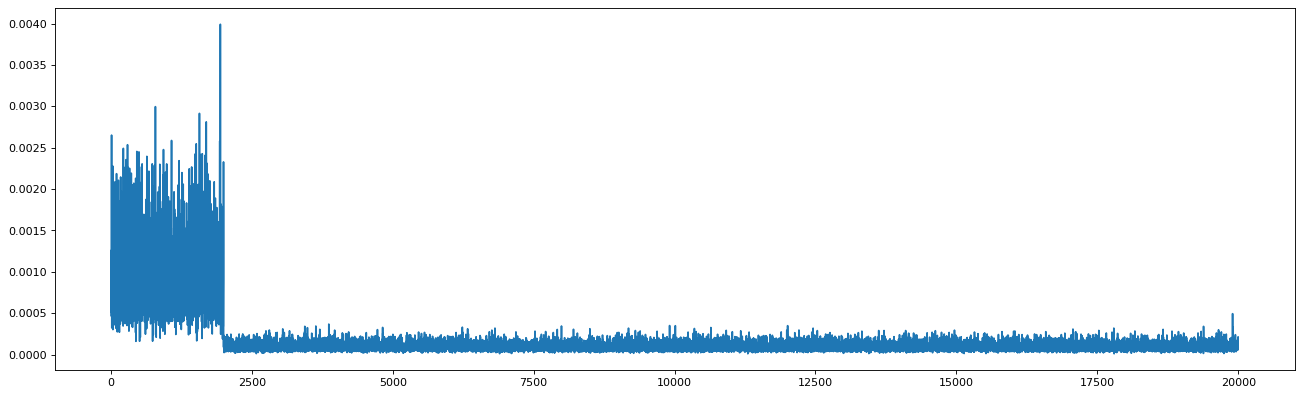

In [409]:
pyplot.figure(num=None, figsize=(20, 6), dpi=80, facecolor='w', edgecolor='k')
pyplot.plot(afsByGene[:, 0, 1:2].flatten())



In [312]:
start = time.time()

l = likelihoodUnivariateFast(altCountsByGene, pDs)

print(l(.001, .01))

time.time() - start

gene sums tensor([10., 10., 16.,  8., 11.,  5., 18.,  4., 19., 12.])
component0 tensor([-2.3691, -0.0995, -0.1592, -2.5701, -0.1094, -0.0497, -1.8668, -0.0398,
        -1.8232, -5.0700])
component1 tensor([-4.6142e-02, -1.0005e-04, -1.6008e-04, -4.8353e-02, -1.1005e-04,
        -5.0025e-05, -4.0344e-02, -4.0021e-05, -3.9813e-02, -9.6359e-02])
tensor(11285.2695)


0.007719278335571289

In [318]:
print(l(0, 0))

component0 tensor([-2.3930, -0.1005, -0.1608, -2.5961, -0.1106, -0.0503, -1.8857, -0.0402,
        -1.8416, -5.1212])
component1 tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0.])
tensor(11215.3643)
